# 01. Data Download and Preprocessing

Author: Minghang Li

In [19]:
# importing all required packages & notebook extensions at the start of the notebook
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization

%matplotlib inline

In [20]:
# assigning variables throughout the notebook

# location of this week's data and all the results produced by this notebook
# - this should be a path relative to your working directory
raw_data_dir = "../data/raw"
data_dir = "../data/processed"
vis_dir  = "../results"

## Download data

Donload the data from polybox.

Original data are stored in `<project-root>/data/raw` (please refrain from editting it!).

In [4]:
%%bash -s $raw_data_dir $data_dir $vis_dir
# Please do NOT modify this cell - here we copy the required data into
# your personal Jupyter workspace.

mkdir -p "$1" "$2" "$3"
chmod -R +rxw "$1" "$2" "$3"

In [5]:
# this will download the sequence data to <project-root>/data/raw/sequencs.qza
! aria2c --max-connection-per-server="$(nproc)" \
    --allow-overwrite=true \
    -d "$raw_data_dir" \
    "https://polybox.ethz.ch/index.php/s/lCmJYEDg5Xz1FEA/download"


10/16 06:33:50 [NOTICE] Downloading 1 item(s)

10/16 06:33:50 [NOTICE] Allocating disk space. Use --file-allocation=none to disable it. See --file-allocation option in man page for more details.
[#b631a3 6.5GiB/6.7GiB(97%) CN:5 DL:488MiB]0m]mGiB(95%)]
10/16 06:34:23 [NOTICE] Download complete: ../data/raw/sequences.qza

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
b631a3|OK  |   310MiB/s|../data/raw/sequences.qza

Status Legend:
(OK):download completed.


In [6]:
# this will download the metadata to <project-root>/data/raw/metadata.tsv
! aria2c --max-connection-per-server="$(nproc)" \
    --allow-overwrite=true \
    -d "$raw_data_dir" \
    "https://polybox.ethz.ch/index.php/s/JrwER5E9kpgGuWd/download"


10/16 06:34:23 [NOTICE] Downloading 1 item(s)

10/16 06:34:23 [NOTICE] Download complete: ../data/raw/metadata.tsv

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
f18c08|OK  |   245KiB/s|../data/raw/metadata.tsv

Status Legend:
(OK):download completed.


In [7]:
# peek at the data
! qiime tools peek $raw_data_dir/sequences.qza

UUID:        058d7a5b-dd47-427e-b047-e5563adaefee
Type:        SampleData[PairedEndSequencesWithQuality]
Data format: SingleLanePerSamplePairedEndFastqDirFmt


In [3]:
meta = pd.read_csv(f"{raw_data_dir}/metadata.tsv", sep="\t")
meta.head()

,Sample_Name,Patient_ID,Stool_Consistency,Patient_Sex,Sample_Day,Recovery_Day,Cohort_Number
0,EG2580,P042,liquid,F,13,17.0,2
1,EG2559,P043,liquid,M,15,17.0,2
2,EG2537,P042,liquid,F,0,17.0,1
3,EG2518,P043,liquid,M,0,17.0,1
4,EG2490,P030,formed,F,0,NaN,1


## Data denoising

### Information on provided datasets

1. **Sequences**: The sequences originate from the V3-V4 region of the 16S rRNA gene and were sequenced on an Illumina MiSeq machine. The sequence files contain **demultiplexed** **paired-end** sequences and are provided as a QIIME 2 artifact (semantic type: `SampleData[PairedEndSequencesWithQuality]`).
  - Forward primer: `ACTCCTRCGGGAGGCAGCAG` (len: **20**)
  - Reverse primer: `GGACTACHVGGGTATCTAATCCTGTT` (len: **26**)
2. **Sample metadata**: The metadata table contains additional information on each collected sample. Each row represents a unique sample that can be identified with its unique `Sample_ID`. The remaining columns depict health data of the patient. All date-related values are given **relative to the day of abduction** e.g. Sample_Day of 13 means 13 days post-abduction

According to the information on the provided data:

- If use `dada2` to denoise data, we should use `dada2 denoise-paired` to denoise data
- If use `deblur`, we probably need to join the reads after qc.
- We probably need to trim the primers before denoising.

### Data inspection

Use the `demux summarize` command to get a visual summary of all our samples (Note that this is a very _lengthy_ process! Took ~500s to finish)

In [16]:
! qiime demux summarize \
    --i-data $raw_data_dir/sequences.qza \
    --o-visualization $data_dir/sequences.qzv

Saved Visualization to: ../data/processed/sequences.qzv


In [4]:
Visualization.load(f"{data_dir}/sequences.qzv")

<visualization: Visualization uuid: 2d4cbc57-79fd-4108-ada1-8dcc8cefe099>

### Primer trimming

Use `cutadapt trim-paired` to remove adapter sequences

In [7]:
! qiime cutadapt trim-paired \
    --i-demultiplexed-sequences $raw_data_dir/sequences.qza \
    --p-front-f ACTCCTRCGGGAGGCAGCAG \
    --p-front-r GGACTACHVGGGTATCTAATCCTGTT \
    --o-trimmed-sequences $data_dir/sequences_trimmed.qza

Saved SampleData[PairedEndSequencesWithQuality] to: ../data/processed/sequences_trimmed.qza


In [8]:
! qiime demux summarize \
    --i-data $data_dir/sequences_trimmed.qza \
    --o-visualization $data_dir/sequences_trimmed.qzv

Saved Visualization to: ../data/processed/sequences_trimmed.qzv


In [9]:
Visualization.load(f"{data_dir}/sequences_trimmed.qzv")

<visualization: Visualization uuid: afcca230-00d5-428d-bab5-0aee393eb5e2>

### Sequencing quality-based truncation parameter selection

First, load the statistics in `sequences_trimmed.qzv`

In [21]:
# To inspect truncate & trim

qza = f"{data_dir}/sequences_trimmed.qzv"
a = !unzip -o $qza
digest = a[1].split('/')[0].replace("  inflating: ","")
fname_fwd = os.path.join(digest, "data/forward-seven-number-summaries.tsv")
fname_rev = os.path.join(digest, "data/reverse-seven-number-summaries.tsv")
fwd = pd.read_csv(fname_fwd, sep="\t", index_col=[0])
rev = pd.read_csv(fname_rev, sep="\t", index_col=[0])
!rm -r $digest

We want to truncate at a position where the quality scores start to decline consistantly.

I'm using the following criterion to programmatically choose truncate position `p`:

* The positions before `p` all have meidian q-score > 30
* The positions after `p` have average 25th percentile q-score < 25

In [39]:
def choose_truncation_site(df, score_median=30, score_q1 = 25, rev=False):
    """
    Choose a truncation site `p` based on the following criteria
    1. all meidan q-score before `p` >= score_median
    2. average lower quatile (q1) q-score after `p` < score_q1
    3. if rev=False, take the smallest position that satisfies 1. and 2. (more stringent)
       otherwise, take the largest position that satisfies 1. and 2.
    """
    low = 0
    high = len(df.columns) - 1

    def _is_valid_truncation_site(df, col):
        # 4th row 50% quantile
        crit1 = np.all(df.iloc[4, :col] >= score_median)
        # 3rd row 25% quantile
        crit2 = df.iloc[3, col:].mean() < score_q1
        return crit1 and crit2
    
    it = range(len(df.columns))
    if rev:
        it = range(len(df.columns), 0, -1)
    for i in it:
        # return the first valid truncation site
        if _is_valid_truncation_site(df, i):
            return i


In [23]:
def visualize_truncation(
    df, truncate_size=200, figsize=(25, 5), color="b", save=False, save_path=None
):
    """
    Visualize truncation size for sequence quality control
    """
    ## TODO: also visualize trimming
    # create figure
    fig, ax = plt.subplots(figsize=figsize)

    # create boxplot
    palette = {}
    for i in df.columns:
        if int(i) <= truncate_size:
            palette[i] = color
        else:
            palette[i] = "gray"

    bxpstats = df.iloc[1:].to_dict()
    # rename keys: "50%" -> "med", "25%" -> "q1", "75%" -> "q3"
    #              "9%" -> "whislo", "91%" -> "whishi"
    bxpstats = [{
            "med": v["50%"],
            "q1": v["25%"],
            "q3": v["75%"],
            "whislo": v["9%"],
            "whishi": v["91%"],
            "fliers": [v["2%"],v["98%"]]
        }
        for k, v in bxpstats.items()
    ]
    bxplot = ax.bxp(bxpstats, patch_artist=True)
    for i, patch in enumerate(bxplot['boxes']):
        patch.set_facecolor(color if i < truncate_size else "gray")

    # add vertical line for truncation size
    ax.axvline(x=truncate_size, color="r", linestyle="--")
    
    # add a shaded area for everything after the truncation size
    ax.axvspan(truncate_size, len(df.columns), color="gray", alpha=0.5, zorder=-1)

    # add a x line for q score 30, put it at the bottom layer
    ax.axhline(y=30, color="black", linestyle="--", zorder=-233)

    # text for q score 30
    ax.text(
        0,
        30,
        "Q30",
        color="black",
        fontsize=12,
        fontweight="bold",
        bbox=dict(facecolor="white", alpha=0.5),
    )

    # rotate x-axis labels
    ax.set_xticklabels(df.columns,rotation=90)

    # add x, y labels
    ax.set_xlabel("Sequence base position")
    ax.set_ylabel("Quality score")

    # tight layout, no space between boxes
    fig.tight_layout()

    # save figure
    if save:
        fig.savefig(save_path)


In [42]:
trunc_len_f = choose_truncation_site(fwd, score_median=25, score_q1=20, rev=False)
trunc_len_r = choose_truncation_site(rev, score_median=25, score_q1=20, rev=False)

In [43]:
print(f"Forward truncation size: {trunc_len_f};\n"
      f"Reverse truncation size: {trunc_len_r}.")

Forward truncation size: 272;
Reverse truncation size: 227.


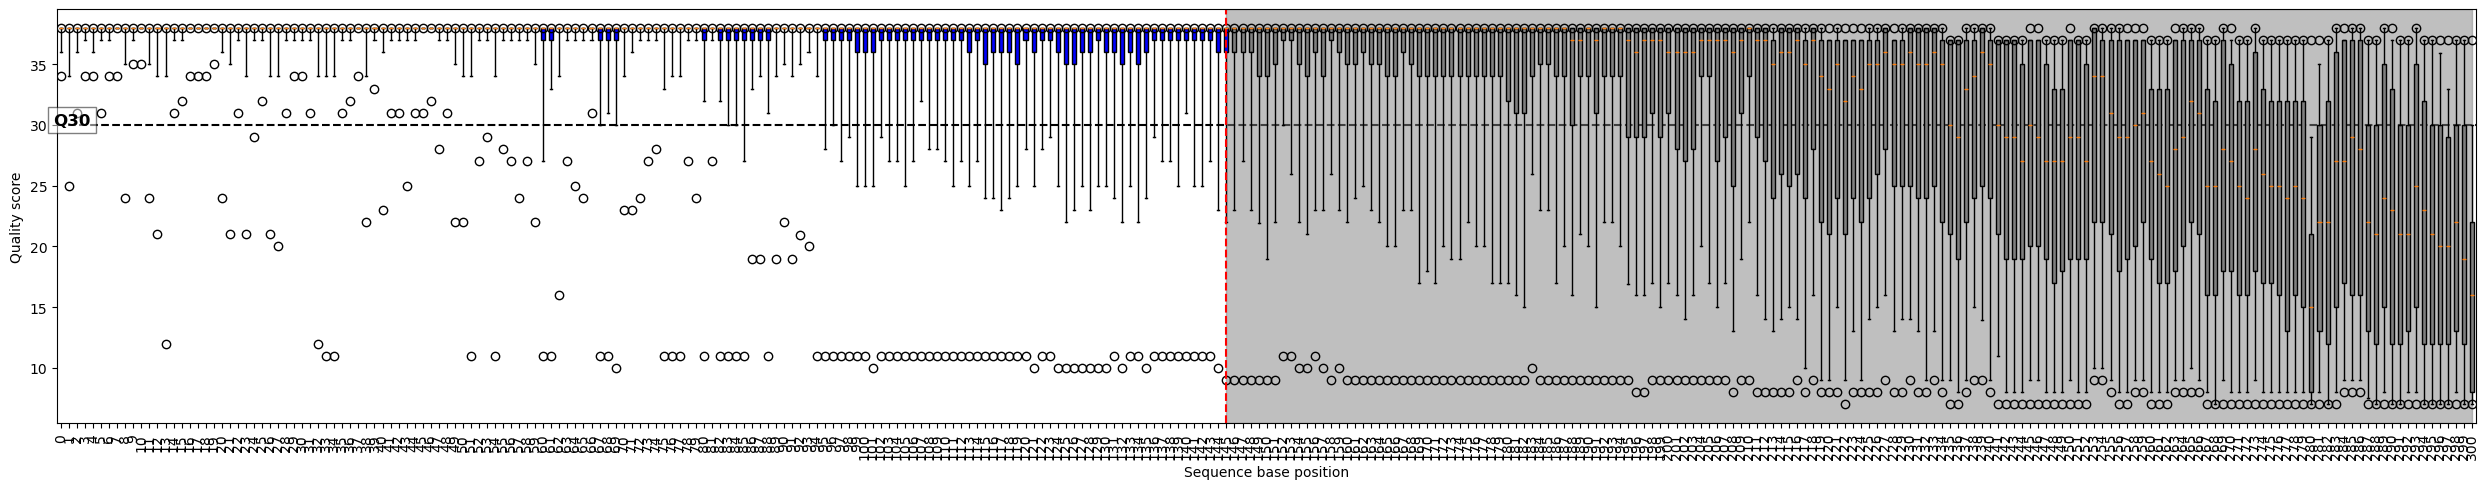

In [26]:
visualize_truncation(
    fwd, truncate_size=trunc_len_f, save=True, save_path=f"{vis_dir}/fwd_truncation_visualization.png"
)

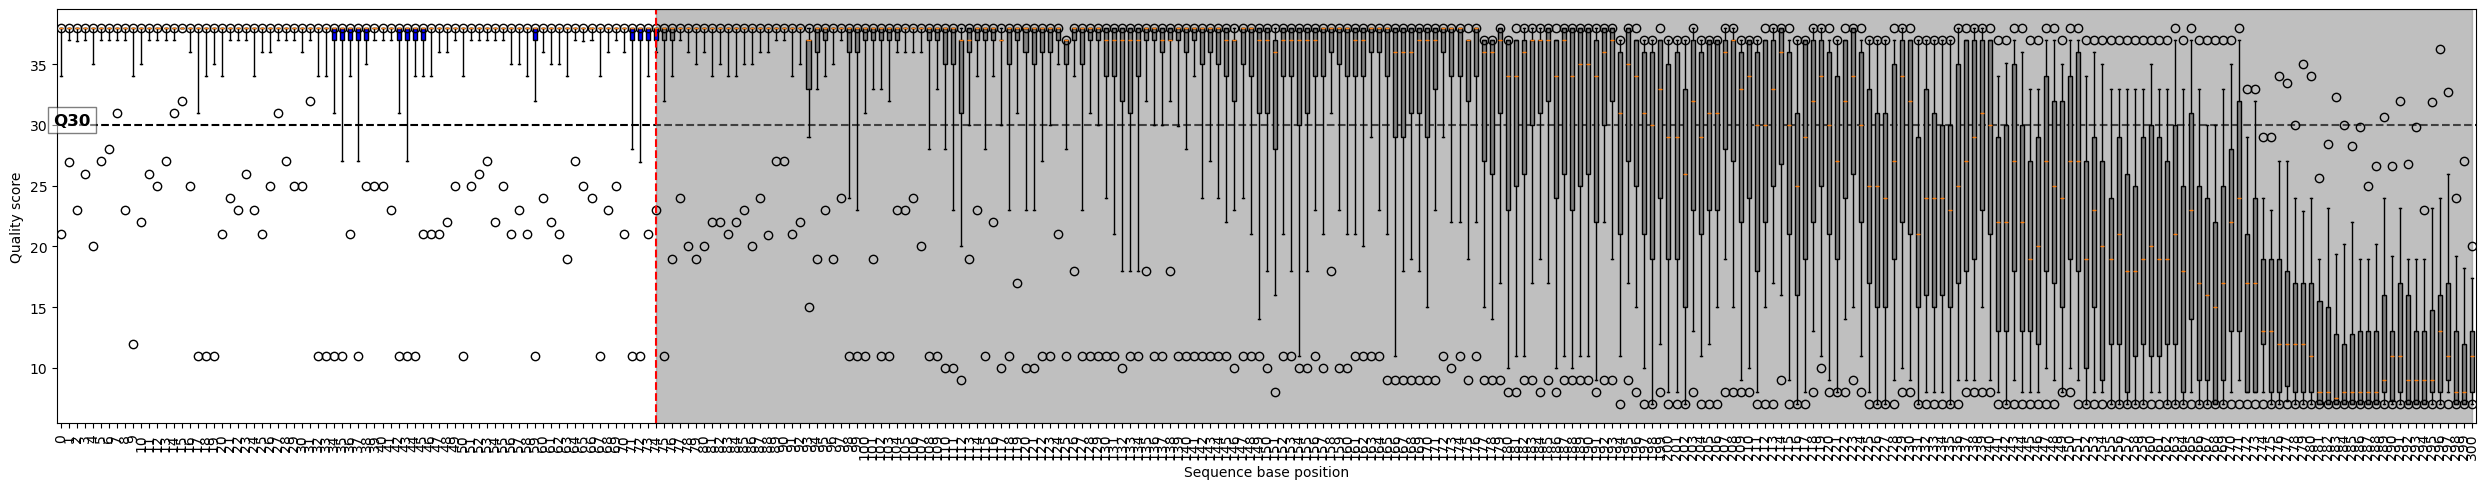

In [27]:
visualize_truncation(
    rev, truncate_size=trunc_len_r, save=True, save_path=f"{vis_dir}/rev_truncation_visualization.png"
)

### Real data denoising

Use `dada2 denoise-paired` to denoise data using the selected parameters.

(As the data is very huge, running more than 4 threads will get the program OOM killed)

In [54]:
! qiime dada2 denoise-paired \
  --i-demultiplexed-seqs $data_dir/sequences_trimmed.qza \
  --p-trunc-len-f 236  \
  --p-trunc-len-r 200 \
  --p-n-threads 4 \
  --o-table $data_dir/table.qza \
  --o-representative-sequences $data_dir/rep-seqs.qza \
  --o-denoising-stats $data_dir/denoising-stats.qza

Saved FeatureTable[Frequency] to: ../data/processed/table.qza
Saved FeatureData[Sequence] to: ../data/processed/rep-seqs.qza
Saved SampleData[DADA2Stats] to: ../data/processed/denoising-stats.qza


## Visualization after denoising

In [67]:
! qiime feature-table summarize \
  --i-table $data_dir/table.qza \
  --o-visualization $data_dir/table.qzv

Saved Visualization to: ../data/processed/table.qzv


In [69]:
Visualization.load(f"{data_dir}/table.qzv")

<visualization: Visualization uuid: 8457fb92-9e0e-4ee5-acbb-bcd2a10c4f02>

In [59]:
! qiime feature-table tabulate-seqs \
  --i-data $data_dir/rep-seqs.qza \
  --o-visualization $data_dir/rep-seqs.qzv

Saved Visualization to: ../data/processed/rep-seqs.qzv


In [60]:
Visualization.load(f"{data_dir}/rep-seqs.qzv")

<visualization: Visualization uuid: aaddcb4d-6f68-485f-b026-72a77d25b808>

In [61]:
! qiime metadata tabulate \
  --m-input-file $data_dir/denoising-stats.qza \
  --o-visualization $data_dir/denoising-stats.qzv

Saved Visualization to: ../data/processed/denoising-stats.qzv


In [62]:
Visualization.load(f"{data_dir}/denoising-stats.qzv")

<visualization: Visualization uuid: 45c658d6-a184-4295-bbd2-d1b901eac27e>

## Bibliography

[1] I. Abellan-Schneyder et al., “Primer, Pipelines, Parameters: Issues in 16S rRNA Gene Sequencing,” _mSphere_, vol. 6, no. 1, Feb. 2021, doi: https://doi.org/10.1128/msphere.01202-20.